# Bleeding Meta-analysis

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

rseeds = [20090425, 19700903]

## Import and clean data

In [2]:
data_file = 'data/Tonsillectomy_Master_Bleeding_Data_Comparative_studies_07212016_JKSK.xlsx'

raw_data = (pd.read_excel(data_file, sheetname='Bleeding all Outcomes',
                         na_values=['null', 'ND', 'NR'])
            .rename(columns={'OUTC_Main_CATG':'outcome_cat',
                            "Outc_SUB_CATG":'outcome_subcat',
                            'OUTCOME_SAMPLE_SIZE': 'N',
                             'Outcome_count': 'outcome_obs',
                            'Outcome_%': 'outcome_pct'}))

raw_data.head()

,Citation,REFID,Child_Paper,Number_of_Arms,Rx_Grouping,Group_Desc,Intervention_category,Dose,Route,Rx_Durn,outcome_cat,outcome_subcat,New_Bleeding_specify,Outcome_timepoint,N,outcome_obs,outcome_pct
0,"K. Murto, C. Lamontagne, C. McFaul, J. MacCorm...",109,NaN,2,G1:,Celecoxib,Preoperative and postoperative NSAID,6 mg/kg and 3 mg/kg post-op,Oral,pre-op and post-op 5 days,Harms,Harms: Post-op bleeding,Undefined bleeding,5 mos post-op,141,8.0,5.7
1,"K. Murto, C. Lamontagne, C. McFaul, J. MacCorm...",109,NaN,2,G2:,Placebo,Placebo,6 mg/kg and 3 mg/kg post-op,Oral,pre-op and post-op 5 days,Harms,Harms: Post-op bleeding,Undefined bleeding,5 mos post-op,141,8.0,5.7
2,"K. Murto, C. Lamontagne, C. McFaul, J. MacCorm...",109,NaN,2,G1:,Celecoxib,Preoperative and postoperative NSAID,6 mg/kg and 3 mg/kg post-op,Oral,pre-op and post-op 5 days,Harms,Harms - Hospital visit for bleeding,Revisit/Readmission-bleeding,5 mos post-op,141,8.0,5.7
3,"K. Murto, C. Lamontagne, C. McFaul, J. MacCorm...",109,NaN,2,G2:,Placebo,Placebo,6 mg/kg and 3 mg/kg post-op,Oral,pre-op and post-op 5 days,Harms,Harms - Hospital visit for bleeding,Revisit/Readmission-bleeding,5 mos post-op,141,7.0,5.0
4,"K. Murto, C. Lamontagne, C. McFaul, J. MacCorm...",109,NaN,2,G1:,Celecoxib,Preoperative and postoperative NSAID,6 mg/kg and 3 mg/kg post-op,Oral,pre-op and post-op 5 days,Harms,Harms-Re-operation for bleeding,Reoperation-bleeding,5 mos post-op,141,3.0,2.1


In [3]:
exclude = 2170,3772,7389

In [4]:
raw_data['Intervention_category'] = raw_data.Intervention_category.str.lower().str.strip()[~raw_data.REFID.isin(exclude)]
clean_data = (raw_data.replace({'Intervention_category':{'saline':'control',
                        'control (no rx)':'control',
                        'control (no dexamethasone)':'control',
                        'no antibiotics':'control',
                        'no steroid':'control',
                        'placebo':'control'},
                        'REFID':{'11238_2480_2506_3102':'11238_2480_2506', 
                                  '1843_1437':'1437_1843', 
                                  '2071_362':'362_2071'}})
              .assign(study_id=raw_data.REFID.astype(str)))

In [5]:
risk_of_bias = (pd.read_excel(data_file, sheetname='ROB_Country_comparative',
                         na_values=['null', 'ND'])[['Refid', 'RoB']]
                )

In [6]:
clean_data.REFID[~clean_data.REFID.astype(str).isin(risk_of_bias.Refid.astype(str).unique())].unique()

array([2170, 3772, 7389, '11238_2480_2506', '1437_1843', '362_2071',
       '3641_a + \n3641_b', '5617_a + 5617_b',
       '806_534_359_164_195_120_205_11584'], dtype=object)

In [7]:
characteristics = (pd.read_excel(data_file, sheetname='BASIC_Charact',
                         na_values=['null', 'ND', 'NR']))[['REFID', 'Surgical_INDICATION']]

In [8]:
characteristics.head()

,REFID,Surgical_INDICATION
0,806_534_359_164_195_120_205_11584,OSDB
1,3241,OSDB
2,546,OSDB
3,2294,OSDB
4,1729,OSDB


In [9]:
merged_data = (clean_data.merge(risk_of_bias.assign(study_id=risk_of_bias.Refid.astype(str)), on='study_id')
                   .merge(characteristics.assign(study_id=characteristics.REFID.astype(str), on='study_id')))

Counts of bleeding outcomes by major category

In [10]:
merged_data.New_Bleeding_specify.value_counts()

Reoperation-bleeding            176
Revisit/Readmission-bleeding    153
Secondary bleeding              124
Primary bleeding                123
Undefined bleeding              113
Unspecified post-op bleeding      5
Name: New_Bleeding_specify, dtype: int64

In [11]:
merged_data.study_id[~merged_data.study_id.isin(characteristics.REFID.astype(str))].unique()

array([], dtype=object)

In [12]:
merged_data.New_Bleeding_specify.value_counts()

Reoperation-bleeding            176
Revisit/Readmission-bleeding    153
Secondary bleeding              124
Primary bleeding                123
Undefined bleeding              113
Unspecified post-op bleeding      5
Name: New_Bleeding_specify, dtype: int64

Here is the full list of intervention categories. For the purposes of this analysis, I will just use the ones with "total" or "partial" in the name, and take them to be surgical interventions.

In [13]:
merged_data.Intervention_category.value_counts()

total cold                                                128
total electrocautery                                      115
total coblation                                            68
control                                                    58
perioperative steroid                                      53
total harmonic scalpel                                     27
total molecular resonance                                  25
partial coblation                                          21
perioperative nsaid                                        18
partial microdebrider                                      15
total thermal welding                                      14
partial cold                                               13
total laser                                                13
partial laser                                              13
postoperative analgesic                                    10
postoperative antibiotic                                    8
total to

Here is the surgery filter:

In [14]:
surgery_data = merged_data[merged_data.Intervention_category.str.contains('total') 
                   | merged_data.Intervention_category.str.contains('partial')].dropna(subset=['outcome_obs']).copy()

List of interventions after filtering. Note that there were a lot of papers that did not report bleeding outcomes, so the numbers dropped significantly. 

In [15]:
surgery_data.Intervention_category.value_counts()

total cold                                  77
total electrocautery                        66
total coblation                             35
total harmonic scalpel                      22
total molecular resonance                   15
total thermal welding                       12
partial laser                               11
partial coblation                           10
partial cold                                 6
partial microdebrider                        6
total laser                                  6
total tonsillectomy - unspecified            4
total electrocautery adenotonsillectomy      3
partial microdebrider adenotonsillectomy     3
partial laser adenotonsillectomy             3
partial tonsillectomy                        2
total tonsillectomy                          2
total not specified                          2
total adenotonsillectomy - unspecified       1
total microdebrider                          1
total electrocautery + total cold            1
total tonsill

Indicator for partial

In [16]:
surgery_data['partial'] = surgery_data.Intervention_category.str.contains('partial')

Generate column for technique

In [17]:
surgery_data['technique'] = (surgery_data.Intervention_category
        .apply(lambda x: ' '.join(x.split(' ')[1:]))
        .replace({'tonsillectomy - coblation':'coblation'}))

surgery_data = surgery_data[~(surgery_data.technique.str.contains('specified')|
                             surgery_data.technique.str.contains('\+'))]

In [18]:
surgery_data.technique.value_counts()

cold                                 83
electrocautery                       67
coblation                            46
harmonic scalpel                     22
laser                                17
molecular resonance                  15
thermal welding                      12
microdebrider                         7
tonsillectomy                         4
laser adenotonsillectomy              3
microdebrider adenotonsillectomy      3
electrocautery adenotonsillectomy     3
Name: technique, dtype: int64

We will analyze the first 7 techniques

In [19]:
technique_includes = surgery_data.technique.value_counts().index.tolist()[:7]
surgery_data = surgery_data[surgery_data.technique.isin(technique_includes)]

In [20]:
technique_includes

['cold',
 'electrocautery',
 'coblation',
 'harmonic scalpel',
 'laser',
 'molecular resonance',
 'thermal welding']

In [21]:
surgery_data.RoB.value_counts()

moderate    132
low          82
high         48
Name: RoB, dtype: int64

In [22]:
surgery_data['high_bias'] = (surgery_data.RoB=='high').astype(int)

In [23]:
surgery_data.Surgical_INDICATION.value_counts()

Both                          83
OSDB                          63
Recurrent Throat infection    43
Other                          2
Name: Surgical_INDICATION, dtype: int64

Drop "Other category"

In [52]:
surgery_data = surgery_data[surgery_data.Surgical_INDICATION!='Other']

Indicators for indications. OSDB is baseline.

In [53]:
surgery_data['Both'] = surgery_data.Surgical_INDICATION.isin(['Both']).astype(int)
surgery_data['RTI'] = surgery_data.Surgical_INDICATION.isin(['Recurrent Throat infection', 'Both']).astype(int)

Subsets of data according to bleeding outcome

In [54]:
readmission_bleeding_data = surgery_data[surgery_data.New_Bleeding_specify=='Revisit/Readmission-bleeding']
reoperation_bleeding_data = surgery_data[surgery_data.New_Bleeding_specify=='Reoperation-bleeding']
primary_bleeding_data = surgery_data[surgery_data.New_Bleeding_specify=='Primary bleeding']
secondary_bleeding_data = surgery_data[surgery_data.New_Bleeding_specify=='Secondary bleeding']

In [55]:
secondary_bleeding_data.Refid.unique().shape, secondary_bleeding_data.shape

((29,), (60, 28))

In [56]:
partial_vc = (surgery_data.assign(removal_type=surgery_data.partial.replace({True: 'partial',
                                                                           False: 'total'}))
                  .groupby('REFID').removal_type.value_counts()).copy()

In [57]:
pd.crosstab(surgery_data.Refid, 
            surgery_data.assign(removal_type=surgery_data.partial.replace({True: 'partial',
                                                                           False: 'total'})).removal_type).to_csv('bleeding_counts.csv')

## Model Specification

We implemented a mixed-effects, arm-based meta-analysis to assess the influence of different surgical procedures as well as the effect of partial vs. full removal procedures on the occurrence of bleeding outcomes following tonsillectomy. The occurrence of bleeding events in most studies are reported as counts, and can therefore be modeled as a binomial response, with inference derived from estimates of the probability of a bleeding event. 

$$x_{ki} \sim \text{Binomial}(n_i, \pi_{ki})$$

where $\pi_{ki}$ is the probability of a bleeding event for intervention $k$ for study $i$. This probability is modeled hierarchically as a logit-linear model with treatment effects and a study-specific random effect as follows:

$$\text{logit}(p_{ki}) = \theta_k + \beta I(\text{partial}_k) + \alpha I(\text{high RoB}_i) + \epsilon_i$$

here, $\theta_k$ is a surgery-specific mean and $\beta$ the effect of a partial removal when $\text{partial}_k$ is true, while $\epsilon_i$ and $\alpha_i$ are a study random effect and a high risk of bias effect, respectively, that  correspond to study $i$.

Logit-linear model parameters were given zero-mean normal priors with $\sigma=5$, which correspond to diffuse information when transformed to the inverse-logit scale. The study random effect was assumed normally distributed with an unknown standard deviation that was estimated from data, with a broad half-Cauchy prior distribution.

This model was fit to each of four bleeding outcome data: re-operation bleeding, re-admission bleeding, primary bleeding, and secondary bleeding.

The models were fit using the No U-turn Sampler (NUTS, Hoffman and Gelman 2014), a self-tuning, gradient-based Markov chaine Monte Carlo (MCMC) algorithm. Models were checked for convergence using the Gelman-Rubin statistic (Gelman and Rubin 1992) and for goodness of fit using posterior predictive checks (Gelman et al. 2013). None of the models showed evidence for lack of convergence or fit using these critera.

In [29]:
from pymc3 import (NUTS, sample, Model, Deterministic, find_MAP,
                  Binomial, Normal, HalfCauchy, advi,
                  traceplot, summary, forestplot, invlogit)
import theano.tensor as tt

In [59]:
def specify_model(data):
    
    N, REFID, events, partial, high_bias, both, rti = data[['N', 'REFID', 'outcome_obs', 'partial', 'high_bias', 'Both', 'RTI']].values.T
    
    refid_list = list(set(REFID))
    study_id = data.REFID.apply(lambda i: refid_list.index(i)).values
    n_studies = len(refid_list)
    
    technique = data.technique.apply(lambda i: technique_includes.index(i)).values
    n_tech = len(technique_includes)
    
    assert not np.isnan(N.astype(int)).any()
    assert not np.isnan(events.astype(int)).any()
    
    with Model() as model:
        
        # Mean for surgery interventions
        θ = Normal('θ', 0, sd=5, shape=n_tech, testval=np.ones(n_tech)*-1)
        # Effect of partial intervention
        β = Normal('β', 0, sd=5, testval=0)
        # Effect of high bias
        ϕ = Normal('ϕ', 0, sd=5, testval=0)
        # Effect of indication
        ψ = Normal('ψ', 0, sd=5, shape=2, testval=np.zeros(2))

        # Study random effect
        σ = HalfCauchy('σ', 5, testval=1)
        ϵ = Normal('ϵ', 0, sd=σ, shape=n_studies, testval=np.zeros(n_studies))

        # Transform to probability scale
        π = invlogit(θ[technique] + β*partial.astype(int) + ϕ*high_bias.astype(int) 
                     + ψ[0]*rti.astype(int) + ψ[1]*both.astype(int) + ϵ[study_id])

        # Mean probabilities
        π_total = Deterministic('π_total', invlogit(θ))
        π_partial = Deterministic('π_partial', invlogit(θ + β))

        # Data likelihood
        obs = Binomial('obs', N.astype(int), π, observed=events.astype(int))

    return model

In [60]:
reoperation_model = specify_model(reoperation_bleeding_data)

Applied log-transform to σ and added transformed σ_log_ to model.


Model run using Hamiltonian Monte Carlo

In [61]:
with reoperation_model:
    reoperation_trace = sample(2000, njobs=2, random_seed=rseeds)

Assigned NUTS to θ
Assigned NUTS to β
Assigned NUTS to ϕ
Assigned NUTS to ψ
Assigned NUTS to σ_log_
Assigned NUTS to ϵ
 [-------100%-------] 2000 of 2000 in 374.1 sec. | SPS: 5.3 | ETA: -0.0

In [62]:
readmission_model = specify_model(readmission_bleeding_data)

Applied log-transform to σ and added transformed σ_log_ to model.


In [63]:
with readmission_model:
    readmission_trace = sample(2000, njobs=2, random_seed=rseeds)

Assigned NUTS to θ
Assigned NUTS to β
Assigned NUTS to ϕ
Assigned NUTS to ψ
Assigned NUTS to σ_log_
Assigned NUTS to ϵ
 [-------100%-------] 2000 of 2000 in 475.0 sec. | SPS: 4.2 | ETA: 0.0

In [64]:
primary_model = specify_model(primary_bleeding_data)

Applied log-transform to σ and added transformed σ_log_ to model.


In [65]:
with primary_model:
    primary_trace = sample(2000, njobs=2, random_seed=rseeds)

Assigned NUTS to θ
Assigned NUTS to β
Assigned NUTS to ϕ
Assigned NUTS to ψ
Assigned NUTS to σ_log_
Assigned NUTS to ϵ
 [-------100%-------] 2000 of 2000 in 725.0 sec. | SPS: 2.8 | ETA: 0.0

In [66]:
secondary_model = specify_model(secondary_bleeding_data)

Applied log-transform to σ and added transformed σ_log_ to model.


In [67]:
with secondary_model:
    secondary_trace = sample(2000, njobs=2, random_seed=rseeds)

Assigned NUTS to θ
Assigned NUTS to β
Assigned NUTS to ϕ
Assigned NUTS to ψ
Assigned NUTS to σ_log_
Assigned NUTS to ϵ
 [-------100%-------] 2000 of 2000 in 368.4 sec. | SPS: 5.4 | ETA: 0.0

## Reoperation Bleeding Results

Posterior traces and histograms of surgical technique bleeding estimates for partial (top plot) and total (bottom plot) removal.

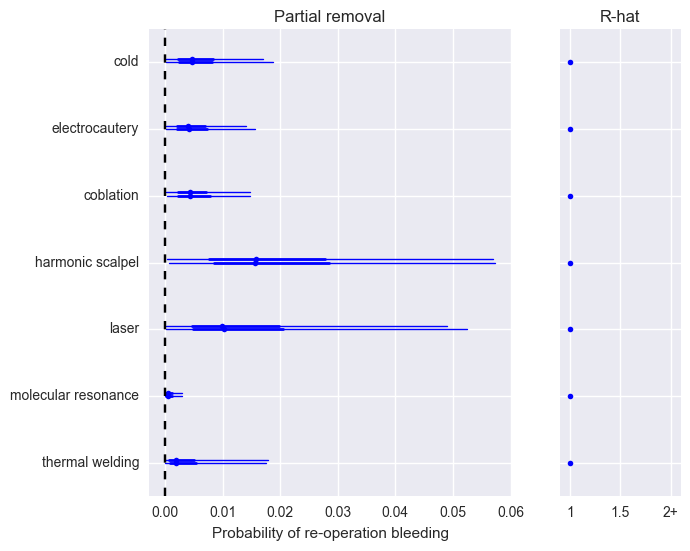

In [68]:
forestplot(reoperation_trace[1000:], varnames=['π_partial'], ylabels=technique_includes, 
           main='Partial removal', xtitle='Probability of re-operation bleeding');

In [69]:
summary(reoperation_trace[1000:], varnames=['π_total', 'π_partial'])


π_total:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.020            0.007            0.000            [0.008, 0.033]
  0.018            0.006            0.000            [0.006, 0.028]
  0.020            0.010            0.000            [0.004, 0.039]
  0.067            0.026            0.001            [0.022, 0.118]
  0.055            0.049            0.001            [0.003, 0.149]
  0.003            0.002            0.000            [0.000, 0.008]
  0.014            0.015            0.000            [0.000, 0.043]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.009          0.015          0.019          0.024          0.037
  0.008          0.013          0.017          0.021          0.031
  0.006          0.012          0.018          0.024          0.043
  0.028 

Estimate of high risk of bias effect, which includes zero within the high density revion of the posterior distribution, suggesting no systematic influence of papers deemed to have high risk of bias.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12266f6a0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11f0c32e8>]], dtype=object)

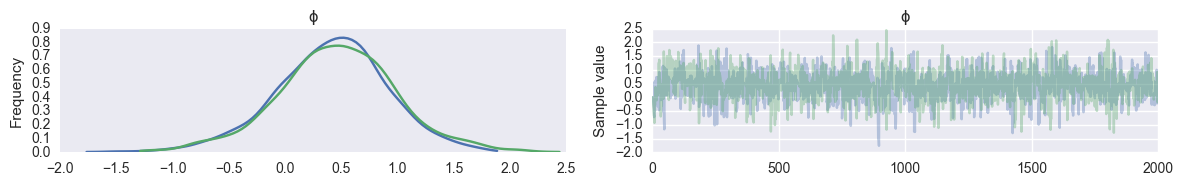

In [70]:
traceplot(reoperation_trace, varnames=['ϕ'])

In [71]:
summary(reoperation_trace, varnames=['ϕ'])


ϕ:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.439            0.520            0.015            [-0.614, 1.530]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.666         0.121          0.457          0.765          1.487



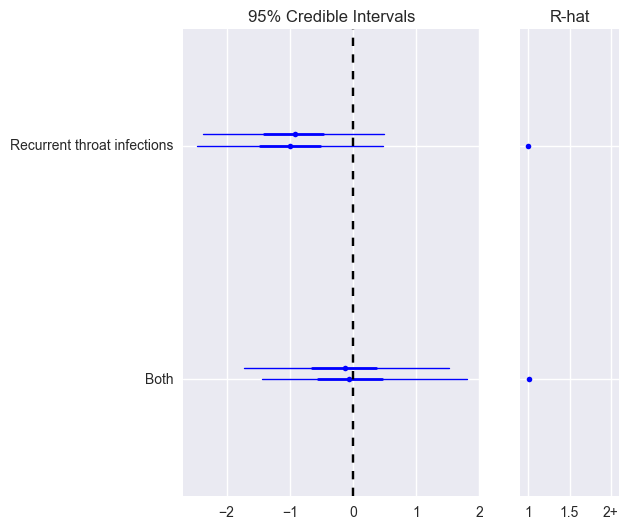

In [73]:
forestplot(reoperation_trace, varnames=['ψ'], ylabels=['Recurrent throat infections', 'Both'])

## Readmission Bleeding Results

Posterior traces and histograms of surgical technique bleeding estimates for partial (top plot) and total (bottom plot) removal.

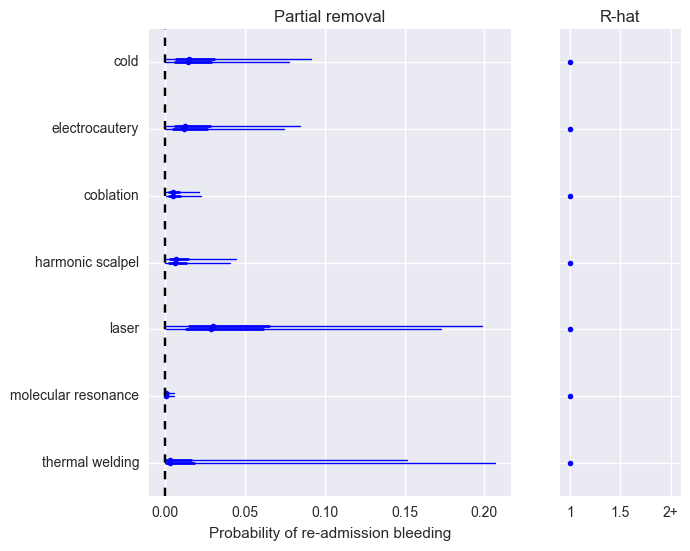

In [74]:
forestplot(readmission_trace[1000:], varnames=['π_partial'], ylabels=technique_includes, 
           main='Partial removal', xtitle='Probability of re-admission bleeding');

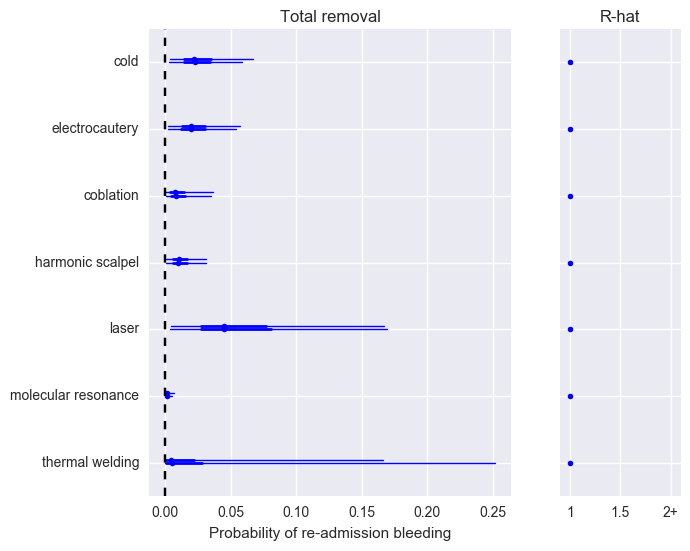

In [75]:
forestplot(readmission_trace[1000:], varnames=['π_total'], ylabels=technique_includes, 
           main='Total removal', xtitle='Probability of re-admission bleeding');

In [39]:
summary(readmission_trace[1000:], varnames=['π_total', 'π_partial'])


π_total:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.027            0.012            0.000            [0.007, 0.049]
  0.029            0.013            0.001            [0.007, 0.053]
  0.014            0.010            0.000            [0.001, 0.033]
  0.015            0.008            0.000            [0.002, 0.031]
  0.057            0.037            0.001            [0.007, 0.126]
  0.002            0.002            0.000            [0.000, 0.006]
  0.027            0.073            0.002            [0.000, 0.127]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.010          0.018          0.025          0.032          0.056
  0.009          0.019          0.026          0.036          0.060
  0.003          0.007          0.011          0.018          0.040
  0.005 

Estimate of high risk of bias effect, which includes zero within the high density revion of the posterior distribution, suggesting no systematic influence of papers deemed to have high risk of bias.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13988fe48>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1390b7ac8>]], dtype=object)

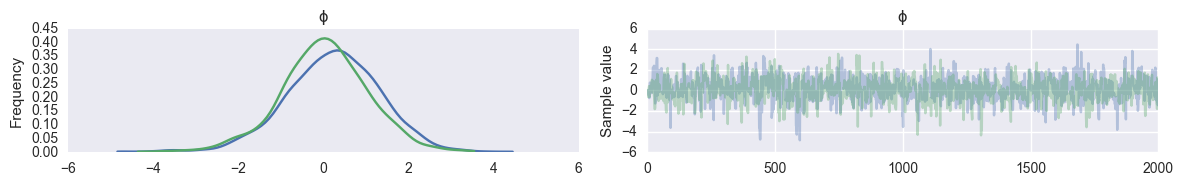

In [76]:
traceplot(readmission_trace, varnames=['ϕ'])

In [77]:
summary(readmission_trace, varnames=['ϕ'])


ϕ:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.127            1.097            0.031            [-2.139, 2.187]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -2.128         -0.545         0.146          0.844          2.199



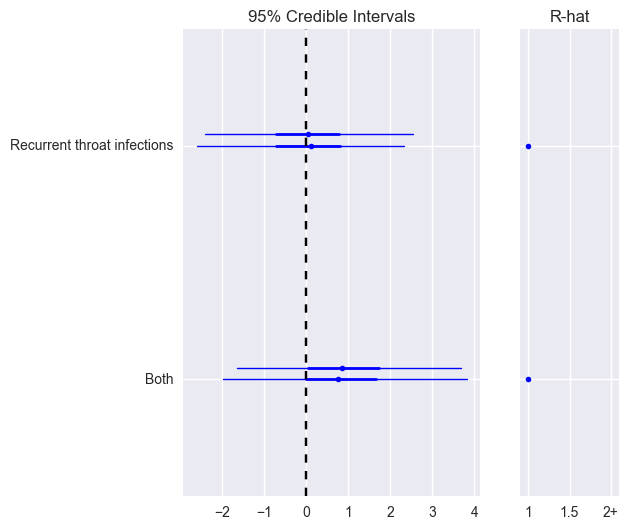

In [78]:
forestplot(readmission_trace, varnames=['ψ'], ylabels=['Recurrent throat infections', 'Both'])

## Primary Bleeding Results

Posterior traces and histograms of surgical technique bleeding estimates for partial (top plot) and total (bottom plot) removal.

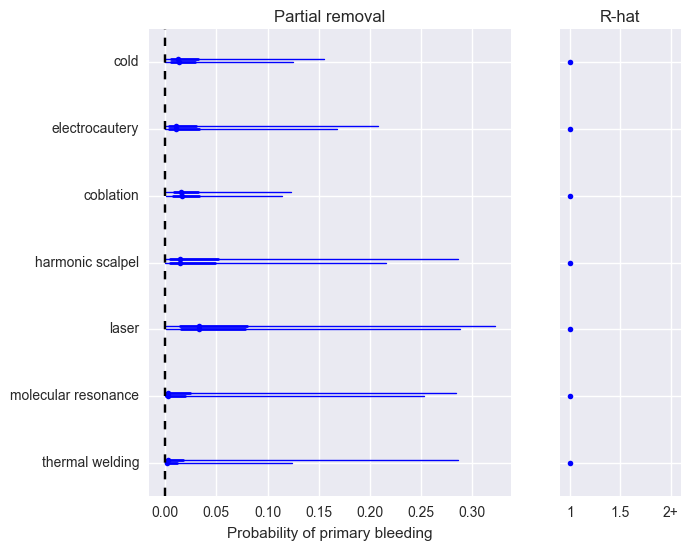

In [79]:
forestplot(primary_trace[1000:], varnames=['π_partial'], ylabels=technique_includes, 
           main='Partial removal', xtitle='Probability of primary bleeding');

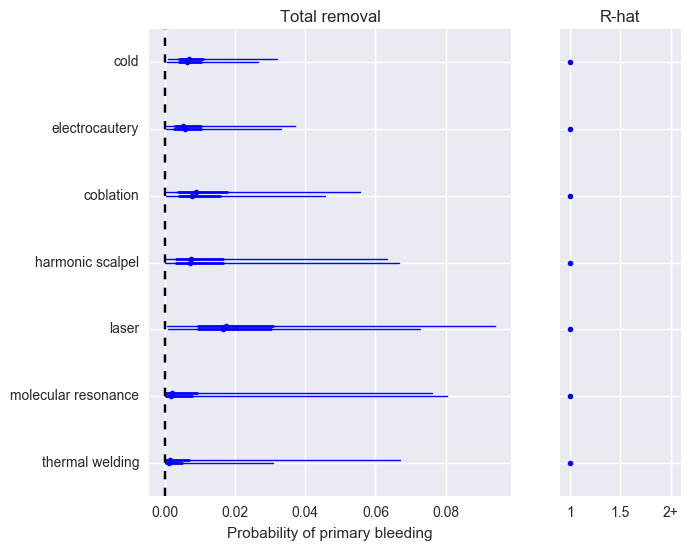

In [80]:
forestplot(primary_trace[1000:], varnames=['π_total'], ylabels=technique_includes, 
           main='Total removal', xtitle='Probability of primary bleeding');

In [81]:
summary(primary_trace[1000:], varnames=['π_total', 'π_partial'])


π_total:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.012            0.038            0.002            [0.001, 0.029]
  0.013            0.041            0.002            [0.000, 0.036]
  0.016            0.034            0.001            [0.000, 0.049]
  0.020            0.054            0.002            [0.000, 0.064]
  0.030            0.058            0.003            [0.001, 0.088]
  0.023            0.099            0.004            [0.000, 0.076]
  0.015            0.069            0.003            [0.000, 0.044]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.001          0.004          0.006          0.011          0.049
  0.001          0.003          0.005          0.010          0.060
  0.001          0.004          0.008          0.016          0.080
  0.001 

Estimate of high risk of bias effect, which includes zero within the high density revion of the posterior distribution, suggesting no systematic influence of papers deemed to have high risk of bias.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13ca40cf8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x13ccb4400>]], dtype=object)

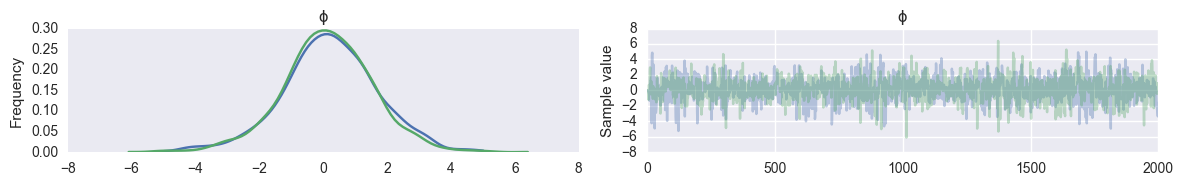

In [82]:
traceplot(primary_trace, varnames=['ϕ'])

In [83]:
summary(primary_trace, varnames=['ϕ'])


ϕ:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.177            1.470            0.036            [-2.677, 3.239]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -2.926         -0.702         0.182          1.107          3.083



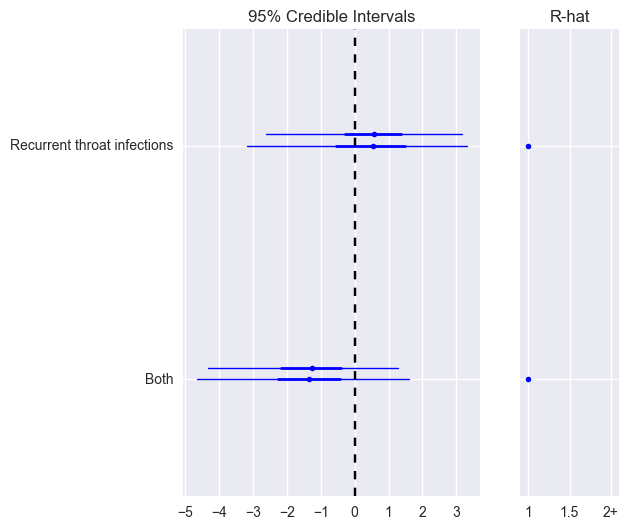

In [84]:
forestplot(primary_trace, varnames=['ψ'], ylabels=['Recurrent throat infections', 'Both'])

## Secondary Bleeding Results

Posterior traces and histograms of surgical technique bleeding estimates for partial (top plot) and total (bottom plot) removal.

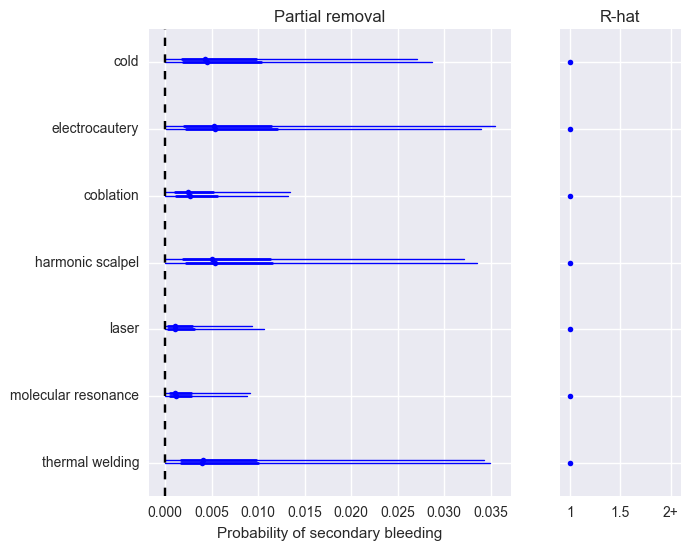

In [85]:
forestplot(secondary_trace[1000:], varnames=['π_partial'], ylabels=technique_includes, 
           main='Partial removal', xtitle='Probability of secondary bleeding');

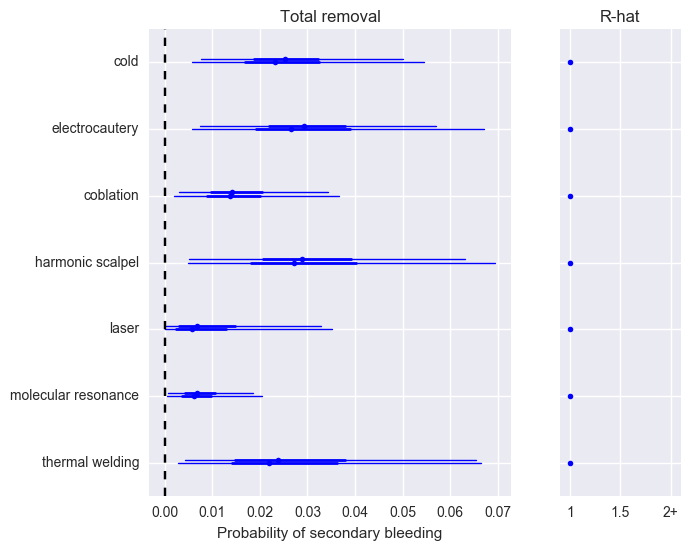

In [86]:
forestplot(secondary_trace[1000:], varnames=['π_total'], ylabels=technique_includes, 
           main='Total removal', xtitle='Probability of secondary bleeding');

<img  src="VEE4JOBWQ3S7W8BGOLP5I588AC2AUK9G.png"/>

In [87]:
summary(secondary_trace[1000:], varnames=['π_total', 'π_partial'])


π_total:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.027            0.013            0.001            [0.006, 0.052]
  0.031            0.016            0.001            [0.006, 0.062]
  0.016            0.010            0.000            [0.003, 0.037]
  0.032            0.017            0.001            [0.005, 0.067]
  0.010            0.012            0.000            [0.000, 0.034]
  0.008            0.006            0.000            [0.000, 0.019]
  0.028            0.021            0.001            [0.003, 0.066]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.009          0.018          0.024          0.032          0.059
  0.010          0.021          0.028          0.039          0.072
  0.004          0.009          0.014          0.020          0.044
  0.009 

Estimate of high risk of bias effect, which includes zero within the high density revion of the posterior distribution, suggesting no systematic influence of papers deemed to have high risk of bias.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13b814cf8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x13ce93c88>]], dtype=object)

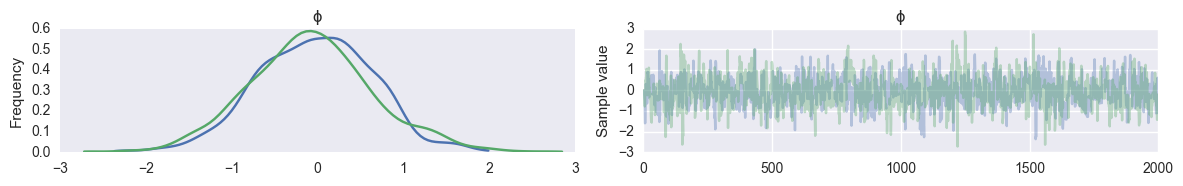

In [88]:
traceplot(secondary_trace, varnames=['ϕ'])

Estimate of high bias effect

In [89]:
summary(secondary_trace, varnames=['ϕ'])


ϕ:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.049           0.706            0.024            [-1.422, 1.383]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -1.410         -0.523         -0.058         0.410          1.403



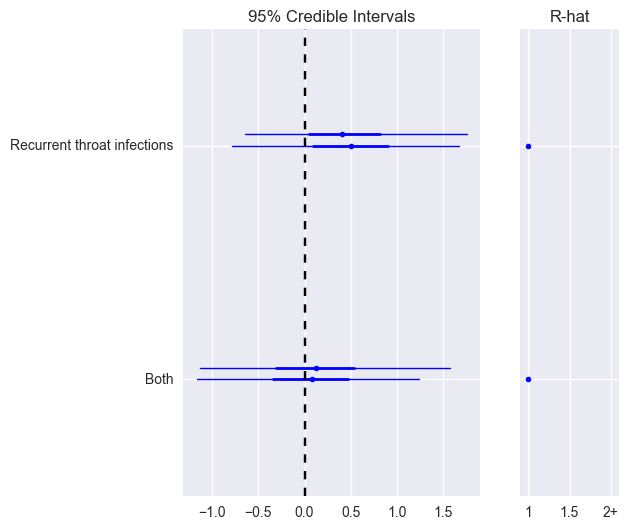

In [90]:
forestplot(secondary_trace, varnames=['ψ'], ylabels=['Recurrent throat infections', 'Both'])

## Goodness of fit

Plots of Bayesian p-values. An excess of very large or very small values may suggest lack of fit.

In [91]:
from pymc3 import sample_ppc

ppc = [sample_ppc(trace, model=model, samples=500) for trace,model in ([reoperation_trace, reoperation_model],
                                                                      [readmission_trace, readmission_model],
                                                                      [primary_trace, primary_model],
                                                                      [secondary_trace, secondary_model])]

In [92]:
bayes_p = lambda sim, true: [(s > t).mean() for s,t in zip(sim, true)]

In [93]:
obs_sim = [p['obs'] for p in ppc]
p_values = [bayes_p(simdata, model.obs.tag.test_value) for simdata,model in zip(obs_sim, 
                                        [reoperation_model, readmission_model, primary_model, secondary_model])]  

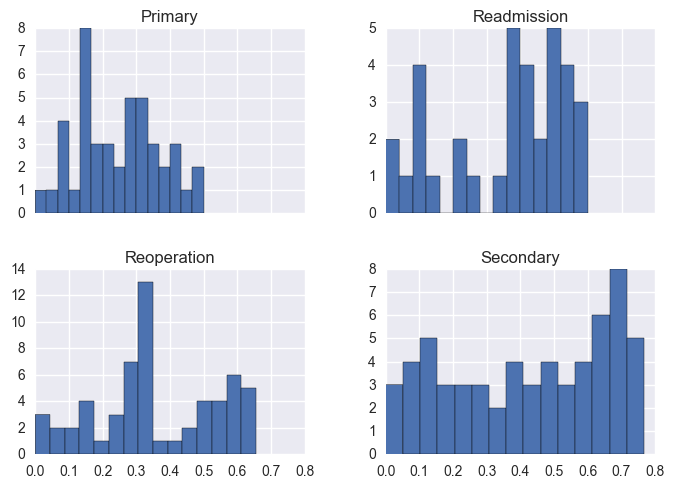

In [94]:
dfp = pd.DataFrame(p_values).T
dfp.columns = 'Reoperation', 'Readmission', 'Primary', 'Secondary'
dfp.hist(sharex=True, bins=15);

# References

1.	Hoffman MD, Gelman A. The No-U-turn sampler: adaptively setting path lengths in Hamiltonian Monte Carlo. The Journal of Machine Learning Research. 2014;15(1):1593-1623.
2.	Gelman A, Rubin DB. Inference from iterative simulation using multiple sequences. Statist Sci. 1992:457-472.
3.	Gelman A, Carlin JB, Stern HS, Dunson DB, Vehtari A, Rubin DB. Bayesian Data Analysis, Third Edition. CRC Press; 2013.